In [284]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


### Welcome!
The following notebook is made to give an idea of what the factorized model does.
It implements a toy model and uses a small synthetic dataset.


### Section 1
Here we define the Factorized embeddings model

This toy model differs from the original models described in the paper by the following:
+ There is one single layer
+ The cost function used here is a cross entropy loss, to go with the binary dataset
+ There is a softmax on the output layer (for the cross entropy loss)

In [285]:
class FactorizedMLP(nn.Module):

    def __init__(self, data, emb_size):
        super(FactorizedMLP, self).__init__()

        self.emb_size = emb_size
        self.inputs_size = data.shape
        
        # Creating the embedding layers.
        self.emb_1 = nn.Embedding(self.inputs_size[1], emb_size)
        self.emb_2 = nn.Embedding(self.inputs_size[0], emb_size)

        # Last layer
        self.last_layer = nn.Linear(emb_size*2, 2)
        # For this specific dataset
        self.softmax = nn.Softmax(dim=1)

    def get_embeddings(self, x):
        # This function fetches the embeddings
        gene, patient = x[:, 0], x[:, 1]
        gene = self.emb_1(gene.long())
        patient = self.emb_2(patient.long())

        return gene, patient

    def forward(self, x):
        # Forward pass on the model
        # Get the embeddings
        emb_1, emb_2 = self.get_embeddings(x)

        # Forward pass through the layers
        mlp_input = torch.cat([emb_1, emb_2], 1)
        mlp_output = self.last_layer(mlp_input)
        mlp_output = self.softmax(mlp_output)

        return mlp_output
    
    def generate_datapoint(self, e):
        ## generating the prototype from a set of sample coordinates e
        ## for all genes:
        emb_1 = self.emb_1.weight.cpu().data.numpy()
        ## create the embedding e
        emb_2 = (np.ones(emb_1.shape[0]*2).reshape((emb_1.shape[0],2)))*e
        ## to tensor + to variable
        emb_1 = torch.FloatTensor(emb_1)
        emb_2 = torch.FloatTensor(emb_2)
        emb_1 = Variable(emb_1, requires_grad=False).float()
        emb_2 = Variable(emb_2, requires_grad=False).float()
        
        ## pass through the mlp
        mlp_input = torch.cat([emb_1, emb_2], 1)
        mlp_output = self.last_layer(mlp_input)
        mlp_output = self.softmax(mlp_output)
        
        return mlp_output
    

### Section 2: The dataset
Here we generate the dataset, a set of binary "gene expressions", where the "gene" is on/off.

The things that may be changed around are:
+ the number of samples
+ the number of attributes

Then, the dataset is processed into thin format, as required for the input/outputs of the factorized embeddings model

In [354]:
nb_examples = 5
nb_attributes = 3
#data = np.random.binomial(1,0.5,nb_attributes*nb_examples).reshape((nb_examples,nb_attributes))
data = np.array([[0,0,0],[1,1,1],[0,0,0],[0,0,1],[1,0,1]])

X_data = np.transpose([np.tile(np.arange(nb_attributes), nb_examples), np.repeat(np.arange(nb_examples), nb_attributes)])
Y_data = data[X_data[:,1], X_data[:,0]]

#### Heatmap of the dataset

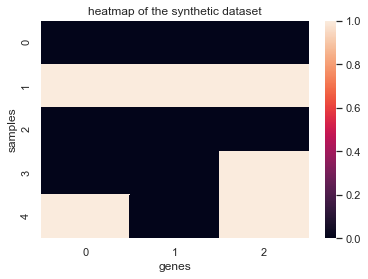

In [355]:

sns.heatmap(data)
plt.title('heatmap of the synthetic dataset')
plt.xlabel('genes')
plt.ylabel('samples')
### This small code fixes the seaborn issue, where the heatmap is cropped
### Solution from SalMac86 @ https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 

plt.show()

### Section 3: Training the model
Here we train the model on the data.

For this specific toy model we use:
+ SGD optimizer with momentum of 0.9
+ a learning rate (lr) of 1e-3
+ a weight decay of 1e-5
+ a CrossEntropy loss

In [356]:
my_model = FactorizedMLP(data, emb_size=2)
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(my_model.parameters(), lr=1e-3, weight_decay=1e-5,momentum=0.9)

#### The training loop
To simplify, no mini-batches are implemented.
The model is trained until the error is below the threshold or until the `max_epoch` is reached

** ** This may take a while! ** **

In [357]:
error = 10000
max_epoch=100000
epoch = 0
error_list = []

while error>1e-5:
    if epoch >= max_epoch:
        print ('too long')
        break

    #print, this is optional!
    elif epoch%5000 == 0: 
        print ('epoch '+str(epoch) + ' , error: '+str(error))

    #inputs and targets to tensor and variable for pytorch
    inputs = torch.FloatTensor(X_data)
    inputs = Variable(inputs, requires_grad=False).long()
    targets = torch.FloatTensor(Y_data)
    targets = Variable(targets, requires_grad=False).long()

    #forward pass
    y_pred = my_model(inputs).float()
    # get the loss
    loss = criterion(y_pred, targets)
    # keep error
    error = loss.cpu().data.numpy().reshape((1,))[0]
    error_list.append(error)
    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # epoch incrementation
    epoch+=1


epoch 0 , error: 10000
epoch 5000 , error: 0.43142354
epoch 10000 , error: 0.39381248
epoch 15000 , error: 0.38571513
epoch 20000 , error: 0.38330215
epoch 25000 , error: 0.3822206
epoch 30000 , error: 0.38161626
epoch 35000 , error: 0.38122335
epoch 40000 , error: 0.38092357
epoch 45000 , error: 0.3806052
epoch 50000 , error: 0.3791608
epoch 55000 , error: 0.32022837
epoch 60000 , error: 0.31719062
epoch 65000 , error: 0.31609455
epoch 70000 , error: 0.31550017
epoch 75000 , error: 0.3151174
epoch 80000 , error: 0.31484708
epoch 85000 , error: 0.3146449
epoch 90000 , error: 0.31448784
epoch 95000 , error: 0.31436217
too long


### Section 4: Analysis
In this section we analyze the embeddings learned by the toy model

#### The learning curve
Here we plot the learning curve of the model

Text(0.5, 0, 'epochs')

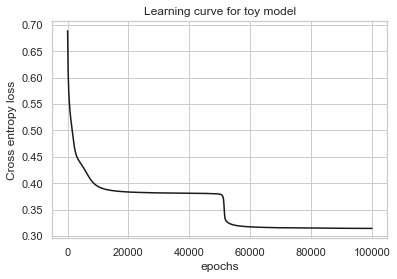

In [358]:
sns.set_style('whitegrid')
plt.plot(range(len(error_list)), error_list, c='k')
plt.title('Learning curve for toy model');
plt.ylabel('Cross entropy loss')
plt.xlabel('epochs')

#### The sample embeddings
Here we plot the sample embeddings the model has learned

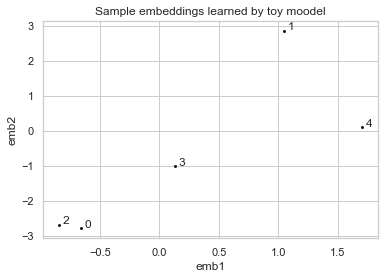

In [359]:
emb = my_model.emb_2.weight.cpu().data.numpy()
plt.scatter(emb[:,0],emb[:,1],c='k', s=4)
n = np.arange(data.shape[0])
for i, txt in enumerate(n):
    plt.annotate(txt, (emb[i,0]+0.03,emb[i,1]+0.03))
plt.xlabel('emb1')
plt.ylabel('emb2')
plt.title('Sample embeddings learned by toy moodel');

#### The gene embeddings
Here we plot the gene embeddings the model has learned

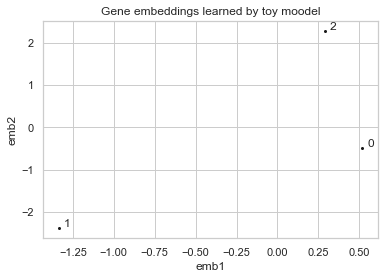

In [360]:
emb = my_model.emb_1.weight.cpu().data.numpy()
plt.scatter(emb[:,0],emb[:,1],c='k', s=4)
n = np.arange(data.shape[1])
for i, txt in enumerate(n):
    plt.annotate(txt, (emb[i,0]+0.03,emb[i,1]+0.03))
plt.xlabel('emb1')
plt.ylabel('emb2')
plt.title('Gene embeddings learned by toy moodel');

#### Conservation of pairwise distances
Here we check if the distances between the samples in embedding space is kept proportional to the distances in original space

In [361]:
import scipy.spatial.distance 

emb = my_model.emb_2.weight.cpu().data.numpy()
distances_original_space = []
distances_embedding_space = []
labels = []
for i in range(data.shape[0]):
    for j in range(data.shape[0]):
        if i<j:
            distances_original_space.append(scipy.spatial.distance.hamming(data[i,:], data[j,:]))
            distances_embedding_space.append(scipy.spatial.distance.euclidean(emb[i,:], emb[j,:]))
            labels.append("_".join([str(i), str(j)]))
        

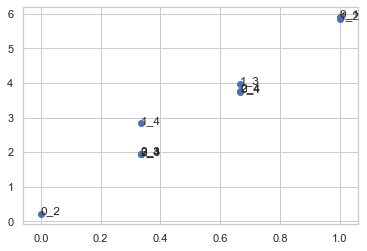

In [362]:
sns.set_style('whitegrid')
plt.scatter(distances_original_space, distances_embedding_space)
for i, txt in enumerate(labels):
    plt.annotate(txt, (distances_original_space[i],distances_embedding_space[i]))

The Pearson correlation here indicates how well the model preserves the sample pairwise distances

In [380]:
np.corrcoef(distances_original_space, distances_embedding_space)[0,1]

0.987960267592639

#### Imputation of data from the embedding space

In this section, we first reconstruct the original data from the embedding coordinates of the samples:

In [382]:
# create an empty array
data_pred = np.zeros((data.shape)) 
# we use the predictions of the last epoch of training (y_pred) as the reconstruction:
for i in np.arange(X_data.shape[0]):
    data_pred[X_data[i,1],X_data[i,0]] = y_pred.cpu().data.numpy()[i][0]

#### comparing the plots between the original and the reconstruction

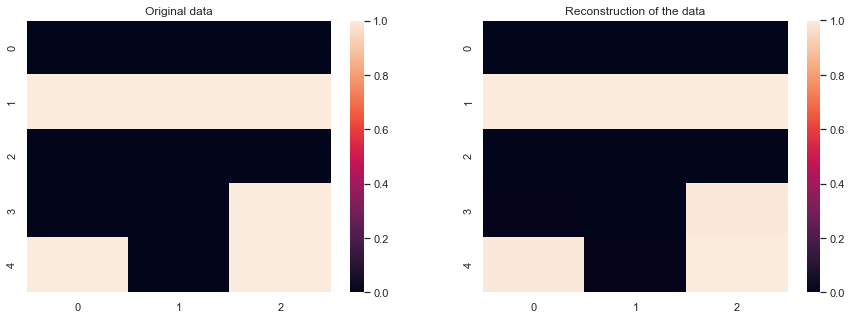

In [393]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.heatmap(data)
### the fix
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 


plt.title('Original data')


plt.subplot(1, 2, 2)
sns.heatmap(1-data_pred)
### the fix
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.title('Reconstruction of the data')
plt.show()


### Generate a mesh

In this section we generate a grid over the embedding space and for each coordinate on that grid, we generate a new prototype sample. This new sample doesn't exist in the original dataset. This operation is done to showcase the imputation and interpolation as well as the organisation of samples in space according to feature values.

In [394]:
def get_min(value):
    return np.min((np.round(value), np.floor(value*100)/100))
def get_max(value):
    return np.max((np.round(value), np.ceil(value*100)/100))


In [395]:
nb_points = 50
x_min = min(emb[:,0])
y_min = min(emb[:,1])
x_max = max(emb[:,0])
y_max = max(emb[:,1])

x = np.linspace(get_min(x_min),get_max(x_max),nb_points)
y = np.linspace(get_min(y_min),get_max(y_max),nb_points)


X_mesh, Y_mesh = np.meshgrid(x,y)
T = []
print (f"I'll be making {(X_mesh.shape[0]*X_mesh.shape[1])**2} samples for a grid of {X_mesh.shape[0]} by {X_mesh.shape[1]} ")
count = 0

for ix,iy in zip(X_mesh.reshape((X_mesh.shape[0]*X_mesh.shape[1],)),Y_mesh.reshape((Y_mesh.shape[0]*Y_mesh.shape[1],))):
    if count%1000==0:
        print(f'made {count} samples')
    T.append(my_model.generate_datapoint([ix,iy]).data.cpu().numpy())
    count+=1

I'll be making 6250000 samples for a grid of 50 by 50 
made 0 samples
made 1000 samples
made 2000 samples


### Plot the mesh - distance to another sample
In this section we plot the mesh of generated samples and colour them by the euclidean distance to each of the samples in the dataset.

In [396]:
new_T = []
for entry in T:
    new_T.append([np.argmax(i) for i in entry]) 

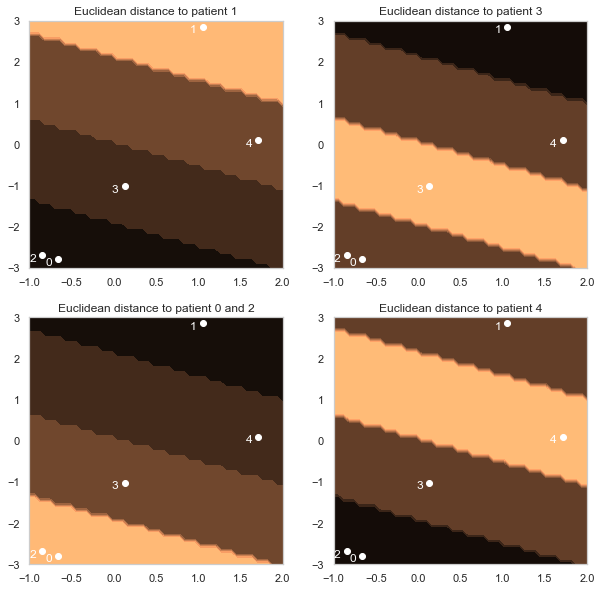

In [410]:
n_col = 2
n_row = 2
fig, axs = plt.subplots(2,2, figsize = (10,10))

for i in range(4):
    row = i%2
    col = i//2
    temp = []
    for g_pt in new_T:
        ### average euclidean distance to the patients of a certain patient
        temp.append(np.linalg.norm(g_pt-data[i+1,:]))
    
    temp = np.array(temp).reshape(X_mesh.shape)
    temp = np.max(temp)-temp

    axs[row ,col].contourf(X_mesh, Y_mesh, temp, cmap='copper')
    axs[row ,col].scatter(emb[:,0],emb[:,1],c='w')

    if i+1==2:
        axs[row ,col].set_title(f'Euclidean distance to patient 0 and {i+1}')
    else:
        axs[row ,col].set_title(f'Euclidean distance to patient {i+1}')
    n = np.arange(data.shape[0])
    for j, txt in enumerate(n):
        axs[row ,col].annotate(txt, (emb[j,0]-0.15,emb[j,1]-0.15),c='w')
        

### Plot the mesh - feature expression
In this section we plot the mesh of generated samples and colour them by feature expression.

These plots at least partly explain how the model places the samples in the embedding space, since it groups them by individual gene expression

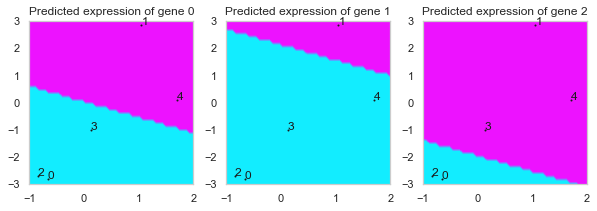

In [489]:
n_col = 3
n_row = 1
fig, axs = plt.subplots(1,3, figsize = (10,3))

for i in range(3):
    row = 0
    col = i
    temp = []
    for g_pt in new_T:
        ### average euclidean distance to the patients of a certain patient
        temp.append(g_pt[i])
    
    temp = np.array(temp).reshape(X_mesh.shape)
    temp = np.max(temp)-temp
    temp = 1-temp

    axs[col].contourf(X_mesh, Y_mesh, temp, cmap='cool')
    axs[col].scatter(emb[:,0],emb[:,1],c='k',s=1)

    axs[col].set_title(f'Predicted expression of gene {i}')
    n = np.arange(data.shape[0])
    for j, txt in enumerate(n):
        axs[col].annotate(txt, (emb[j,0],emb[j,1]),c='k')
        